In [118]:
import numpy as np
import pandas as pd
import json
import datetime
import urllib.request 
import matplotlib.pyplot as plt
import seaborn as snb
from bs4 import BeautifulSoup
import json
import requests
from wordcloud import WordCloud, STOPWORDS
from lxml import etree
from io import StringIO

# Emotional arc analysis - White Fang
In this project I am going to analyze the emotional arc of the novel White Fang by Jack London. The project is divided into three main parts: data scraping, pre-processing, and sentiment-analysis. 

## Scraping the data
I use urllib to scrape the book from this link https://www.gutenberg.org/cache/epub/910/pg910.txt. 

In [13]:
url = "https://www.gutenberg.org/cache/epub/910/pg910.txt"
fang = urllib.request.urlopen(url).read().decode('utf-8')


Remove the unneccessary stuffs

In [40]:
fang = fang.replace('This eBook is for the use of anyone anywhere in the United States','')
fang = fang.replace("\n"," ")
fang = fang.replace("\r", " ")
fang = fang.replace("\ufeff"," ")
fang = fang.replace("The Project Gutenberg eBook of White Fang, by Jack London     and  most other parts of the world at no cost and with almost no restrictions  whatsoever. You may copy it, give it away or re-use it under the terms  of the Project Gutenberg License included with this eBook or online at  www.gutenberg.org. If you are not located in the United States, you  will have to check the laws of the country where you are located before  using this eBook.    Title: White Fang    Author: Jack London    Release Date: May 13, 1997 [eBook #910]  [Most recently updated: November 10, 2021]    Language: English      Produced by: David Price    *** START OF THE PROJECT GUTENBERG EBOOK WHITE FANG ***    [Illustration]          WHITE FANG    by Jack London      Contents     PART I   CHAPTER I THE TRAIL OF THE MEAT   CHAPTER II THE SHE-WOLF   CHAPTER III THE HUNGER CRY     PART II   CHAPTER I THE BATTLE OF THE FANGS   CHAPTER II THE LAIR   CHAPTER III THE GREY CUB   CHAPTER IV THE WALL OF THE WORLD   CHAPTER V THE LAW OF MEAT     PART III   CHAPTER I THE MAKERS OF FIRE   CHAPTER II THE BONDAGE   CHAPTER III THE OUTCAST   CHAPTER IV THE TRAIL OF THE GODS   CHAPTER V THE COVENANT   CHAPTER VI THE FAMINE     PART IV   CHAPTER I THE ENEMY OF HIS KIND   CHAPTER II THE MAD GOD   CHAPTER III THE REIGN OF HATE   CHAPTER IV THE CLINGING DEATH   CHAPTER V THE INDOMITABLE   CHAPTER VI THE LOVE-MASTER     PART V   CHAPTER I THE LONG TRAIL   CHAPTER II THE SOUTHLAND   CHAPTER III THE GOD’S DOMAIN   CHAPTER IV THE CALL OF KIND   CHAPTER V THE SLEEPING WOLF          PART I          CHAPTER I  THE TRAIL OF THE MEAT      "," ")

## Pre-processing
In this preprocessing process, I will first remove stop words and split the novel into smaller corpus.
For both pre-processing and analysis, I will be using nltk package for removing stopwords, tokenizing, and dictionary-based analysis. 

In [194]:
import nltk
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import opinion_lexicon
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer as SIA
import nltk.sentiment
tokenizer = RegexpTokenizer(r'\w+')

nltk.download('opinion_lexicon') #Download Opinion Dictionary
positive_wds = set(opinion_lexicon.positive())
negative_wds = set(opinion_lexicon.negative())



[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/duongton/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


Remove stopwords

In [64]:
#remove stopwords using genism library
removestopfang = remove_stopwords(fang)

To keep the context. I will slice the novel into sentences, which I will append to dataframe and conduct dictionary-based sentiment analysis on each sentence. 

In [188]:
#sentence tokenizing
words = sent_tokenize(removestopfang)
words = words[:4800]


In [130]:
df = pd.DataFrame(words,columns=['corpus'])
df

,corpus
0,Dark spruce forest frown freeze waterway .
1,"The tree strip recent wind white cover frost ,..."
2,A vast silence reign land .
3,"The land desolation , lifeless , movement , lo..."
4,"There hint laughter , laughter terrible sadnes..."
...,...
4795,"He surprise , look puzzle way ."
4796,"Then weakness assert , lay , ears cock , head ..."
4797,"The puppies come sprawl , Collie ’ s great dis..."
4798,"At , amid applause gods , betray trifle old se..."


## Lexicon-based Sentiment Analysis
Next, count the number of positive words in the text, which then use to compute the score of positive/negative in the corpus. The computation is as followed:
* Cross-check words in the corpus with words in positive and negative list
* Count the number of positive and negative words in the corpus
* the score is computed as (pos - neg)/total


In [111]:
#write a function for scoring
def score(cor):
    "score senetiment for corpus from -1 to 1"
    words = tokenizer.tokenize(cor) #word tokenize the sentence
    pos = len([a for a in words if a in positive_wds])
    neg = len([a for a in words if a in negative_wds])
    if len(words)>0:
        score = (pos - neg)/len(words)
    else: 
        return 0
    return score


In [112]:
df['score']=df['corpus'].apply(score)
df.head()

Text(0.5, 0, 'Emotional Arc of White fang')

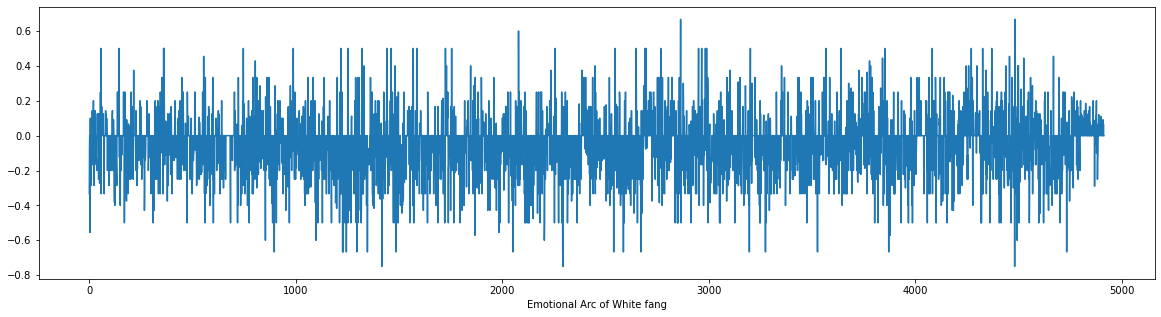

In [121]:
ax = df['score'].plot(kind='line',figsize=(20,5))
ax.set_xlabel('Emotional Arc of White fang')

From the graph, it seems like White Fang has a rather dark/serious tone. Throughout the whole story, the score leans towards to negative rather than positive, which makes sense cause White Fang deals with various depressing topics like bullying, fighting deaths, and harshness. The maximum absolute score of negative is around .8 while it would be around .6 for positive. The story gets a little more upbeat towards the end of the story. The window of analysis (sentence) seems too small, making it difficult to discern the larger trend. Therefore, in the next sections, I will change the window of analysis.


## Changing the window size

The two functions for slicing are from this website https://indicodata.ai/blog/plotlines/

### 30-word window

In [164]:
def sample_window(seq, window_size , stride ):
    for pos in range(0, len(seq), stride):
        yield seq[pos : pos + window_size]

In [165]:
def merge(seq, stride):
    """
    Generator strides across the input sequence, 
    combining the elements between each stride.
    """
    for pos in range(0, len(seq), stride):
        yield seq[pos : pos + stride]

In [189]:
merged_words = [" ".join(w) for w in merge(words, 30)]
merged_words
# Sample a sliding window of context
delim = " "
samples = [delim.join(s) for s in sample_window(merged_words, 2, 1)]
df2 = pd.DataFrame(samples,columns=['corpus'])

<AxesSubplot:>

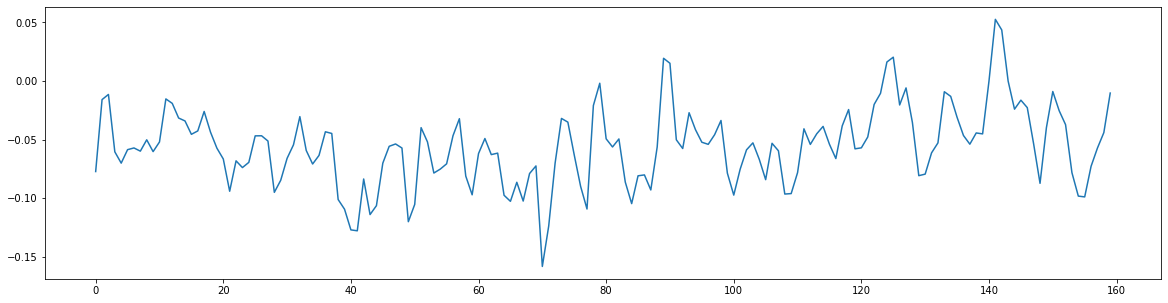

In [191]:
df2['score']=df2['corpus'].apply(score)
df2['score'].plot(kind='line',figsize =(20,5))

This definitely looks clearer and better. And highest positive score (approx.5) of the story in this 30-word window analysis is higher than the absolute value of the negative score (~.15)

### 50-word window

In [192]:
merged_words = [" ".join(w) for w in merge(words, 50)]
delim = " "
samples = [delim.join(s) for s in sample_window(merged_words, 3, 1)]
df2 = pd.DataFrame(samples,columns=['corpus'])
df2.head()

,corpus
0,Dark spruce forest frown freeze waterway . The...
1,"The wolf-dogs , cluster far , snarl bicker , e..."
2,"” Cry , answer , turn silence bedlam . From ar..."
3,Once uproar loud Bill wake . He bed carefully ...
4,"“ It half , ” announce ; “ I whack jes ’ . D ’..."
...,...
91,"He avoid pass porch , corner rocking-chair rai..."
92,Punishment fail break spirit . He die dumb-mad...
93,Jim Hall believe judge know hand glove police ...
94,"“ Jim Hall , ” Judge Scott , father son look s..."


<AxesSubplot:>

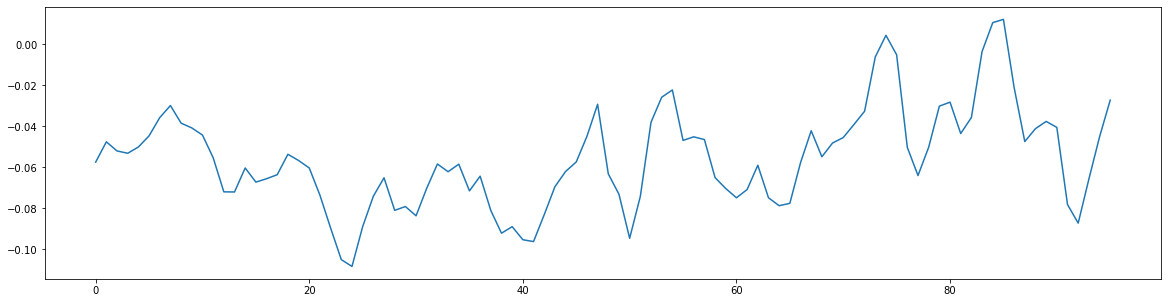

In [193]:
df2['score']=df2['corpus'].apply(score)
df2['score'].plot(kind='line',figsize =(20,5))

It seems like there are lots of ups and downs throughout the whole story. In general it starts off by rising during the first 1/10 of the story only to get to the bottom at the 1/5 of the story. It keeps going ups and downs like how White Fang is acquired by different owners throughout the story. Probably around the 4/5 when the story reaches the highest is when White Fang meets Scott who provides White Fang with companionship, care, and love. The story hits the second rock bottom when Scott dies near the end of the story and White Fang killed Scott's murderer. After Scott's death, White Fang returned to the wild, living a content life with his puppies, hence the rise at the end of the story. 